<a href="https://colab.research.google.com/github/0xd1rac/cv-papers/blob/main/rcnn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.7/942.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00

In [2]:
import torch
import fiftyone as fo
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

# 0. Dataset

In [3]:
class CocoDataset(Dataset):
    def __init__(self, fiftyone_dataset, label_map, transform=None):
        self.dataset = fiftyone_dataset
        self.label_map = label_map
        self.transform = transform
        self.filepaths = self.dataset.values("filepath")

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        sample = self.dataset.match({"filepath": filepath}).first()
        image = Image.open(filepath)

        # Check if ground_truth exists
        if sample.ground_truth is None or sample.ground_truth.detections is None:
            # If no ground truth, return an empty target
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            # Get the bounding boxes and labels
            boxes = []
            labels = []
            for detection in sample.ground_truth.detections:
                x, y, w, h = detection.bounding_box
                # Convert bounding box to absolute coordinates
                x_min = x * image.width
                y_min = y * image.height
                x_max = (x + w) * image.width
                y_max = (y + h) * image.height
                boxes.append([x_min, y_min, x_max, y_max])

                # Convert the label from string to integer
                label = self.label_map.get(detection.label, 0)  # default to 0 if label not found
                labels.append(label)

            # Convert to tensors
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target


In [4]:
import fiftyone.zoo as foz

def get_coco_datasets(train_transform=None,
                      val_transform=None,
                      test_transform=None,
                      batch_size=8,
                      shuffle=True,
                      num_workers=4,
                      collate_fn=lambda x: tuple(zip(*x)),
                      max_train_samples=3,
                      max_val_samples=2,
                      max_test_samples=2
                      ):
  train_dataset = foz.load_zoo_dataset("coco-2017", split="train", max_samples=max_train_samples)
  val_dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=max_val_samples)
  test_dataset = foz.load_zoo_dataset("coco-2017", split="test", max_samples=max_test_samples)

  unique_labels = train_dataset.distinct("ground_truth.detections.label")
  label_map = {label: idx + 1 for idx, label in enumerate(unique_labels)}

  train_coco_dataset = CocoDataset(train_dataset, label_map, transform=train_transform)
  val_coco_dataset = CocoDataset(val_dataset, label_map, transform=val_transform)
  test_coco_dataset = CocoDataset(test_dataset, label_map, transform=test_transform)

  # train_loader = DataLoader(train_coco_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
  # val_loader = DataLoader(val_coco_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
  # test_loader = DataLoader(test_coco_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
  return train_coco_dataset, val_coco_dataset, test_coco_dataset, label_map


In [5]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_random_sample_from_coco(dataset, label_map):
    # Select a random sample (image, target) tuple from the dataset
    image, target = random.choice(dataset)

    # Convert the PIL image to a numpy array
    image = np.array(image)

    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Get the bounding boxes and labels from the target
    boxes = target['boxes'].numpy()  # Assuming boxes are already in pixel coordinates
    labels = target['labels'].numpy()

    # Reverse the label map to get the label names
    reverse_label_map = {v: k for k, v in label_map.items()}

    # Plot the bounding boxes and labels
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add the label text
        label = reverse_label_map.get(labels[i], "unknown")
        plt.text(x_min, y_min, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    # Display the plot with the image, bounding boxes, and labels
    plt.axis('off')  # Hide axes
    plt.show()


In [6]:
train_coco_dataset, val_coco_dataset, test_coco_dataset, label_map = get_coco_datasets()

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [8.0s elapsed, 0s remaining, 486.0Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [8.0s elapsed, 0s remaining, 486.0Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Downloading 3 images


 100% |██████████████████████| 3/3 [644.7ms elapsed, 0s remaining, 4.7 images/s]      


INFO:eta.core.utils: 100% |██████████████████████| 3/3 [644.7ms elapsed, 0s remaining, 4.7 images/s]      


Writing annotations for 3 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 3 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


 100% |█████████████████████| 3/3 [47.9ms elapsed, 0s remaining, 62.7 samples/s]     


INFO:eta.core.utils: 100% |█████████████████████| 3/3 [47.9ms elapsed, 0s remaining, 62.7 samples/s]     


Dataset 'coco-2017-train-3' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-train-3' created


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading 2 images


 100% |██████████████████████| 2/2 [410.4ms elapsed, 0s remaining, 4.9 images/s]      


INFO:eta.core.utils: 100% |██████████████████████| 2/2 [410.4ms elapsed, 0s remaining, 4.9 images/s]      


Writing annotations for 2 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 2 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |█████████████████████| 2/2 [71.1ms elapsed, 0s remaining, 28.1 samples/s]     


INFO:eta.core.utils: 100% |█████████████████████| 2/2 [71.1ms elapsed, 0s remaining, 28.1 samples/s]     


Dataset 'coco-2017-validation-2' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation-2' created


INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/coco-2017/test' if necessary


INFO:fiftyone.utils.coco:Downloading test info to '/root/fiftyone/coco-2017/tmp-download/image_info_test2017.zip'


 100% |██████|    8.7Mb/8.7Mb [308.2ms elapsed, 0s remaining, 28.3Mb/s]      


INFO:eta.core.utils: 100% |██████|    8.7Mb/8.7Mb [308.2ms elapsed, 0s remaining, 28.3Mb/s]      


Extracting test info to '/root/fiftyone/coco-2017/raw/image_info_test2017.json'


INFO:fiftyone.utils.coco:Extracting test info to '/root/fiftyone/coco-2017/raw/image_info_test2017.json'


INFO:fiftyone.utils.coco:Downloading 2 images


 100% |██████████████████████| 2/2 [408.0ms elapsed, 0s remaining, 4.9 images/s]      


INFO:eta.core.utils: 100% |██████████████████████| 2/2 [408.0ms elapsed, 0s remaining, 4.9 images/s]      


Writing annotations for 2 downloaded samples to '/root/fiftyone/coco-2017/test/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 2 downloaded samples to '/root/fiftyone/coco-2017/test/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'test'


 100% |█████████████████████| 2/2 [43.0ms elapsed, 0s remaining, 46.5 samples/s]     


INFO:eta.core.utils: 100% |█████████████████████| 2/2 [43.0ms elapsed, 0s remaining, 46.5 samples/s]     


Dataset 'coco-2017-test-2' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-test-2' created


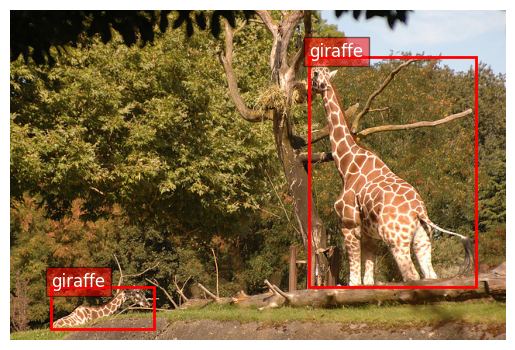

In [7]:
visualize_random_sample_from_coco(train_coco_dataset, label_map)

# 1. Pretraining on the classification task on the imagenet dataset - just use VGG16 pretrained

In [8]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.5MB/s]


# 2. Domain Specific Fine Tuning

## 2.1 Dataset Preparation
1. Perform selective search to come up with region proposals where objects might exists
2. Label the region proposals by calculating IoU with ground truth boxes. If IoU >= 0.5, label the region proposal with ground truth label, or else label it as background

In [12]:
!pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4334 sha256=84326460b9484728983166da143e32b7d2535bb6e91d9983790e8b24fe283392
  Stored in directory: /root/.cache/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch


In [20]:
label_map['background'] = 0

In [13]:
import torch
from torch.utils.data import Dataset
import selectivesearch
import numpy as np
from PIL import Image

class CustomObjectDetectionDataset(Dataset):
    def __init__(self,
                 dataset,
                 label_map,
                 crop_size=(224, 224),
                 transform=None
                 ):
        """
        Args:
            dataset: A dataset of (image, target) tuples.
            label_map: A dictionary mapping class labels to integers.
            crop_size: Tuple specifying the (width, height) to which all crops will be resized.
            transform: Optional transform to be applied on a sample.
        """
        self.dataset = dataset
        self.label_map = label_map
        self.crop_size = crop_size
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def calculate_iou(self, box1, box2):
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2

        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        inter_width = max(0, x_inter_max - x_inter_min)
        inter_height = max(0, y_inter_max - y_inter_min)
        inter_area = inter_width * inter_height

        box1_area = (x1_max - x1_min) * (y1_max - y1_min)
        box2_area = (x2_max - x2_min) * (y2_max - y2_min)

        iou = inter_area / float(box1_area + box2_area - inter_area)

        return iou

    def perform_selective_search(self, image):
        # Convert the image to a numpy array
        img_np = np.array(image)

        # Perform selective search
        _, regions = selectivesearch.selective_search(img_np, scale=500, sigma=0.9, min_size=10)

        # Filter and return bounding boxes
        proposals = []
        for r in regions:
            if r['size'] < 200:
                continue
            x, y, w, h = r['rect']
            proposals.append([x, y, x + w, y + h])

        return proposals

    # Maybe have background_proposals and labeled_proposals - need to sample later
    def label_proposals_with_ground_truth(self, proposals, gt_boxes, gt_labels):
      background_proposals = []
      object_proposals = []
      for proposal in proposals:
          max_iou = 0
          assigned_label = self.label_map['background']  # Default label for background

          for i, gt_box in enumerate(gt_boxes):
              iou = self.calculate_iou(proposal, gt_box)
              if iou >= 0.5 and iou > max_iou:
                  max_iou = iou
                  assigned_label = gt_labels[i]

          proposal_tuple = (proposal, assigned_label)

          if assigned_label == self.label_map['background']:
            background_proposals.append(proposal_tuple)
          else:
            object_proposals.append(proposal_tuple)

      assert all(isinstance(item, tuple) for item in background_proposals), "Background proposals contain non-tuple elements!"
      assert all(isinstance(item, tuple) for item in object_proposals), "Object proposals contain non-tuple elements!"
      return background_proposals, object_proposals

    def get_crops(self, image, proposals):
      assert all(isinstance(item, tuple) for item in proposals), "proposals contain non-tuple elements!"

      crops = []
      for proposal in proposals:
          # Ensure the proposal is correctly structured
          if isinstance(proposal[0], (list, np.ndarray)) and len(proposal[0]) == 4:
              x_min, y_min, x_max, y_max = proposal[0]
              crop = image.crop((x_min, y_min, x_max, y_max))
              crop = crop.resize(self.crop_size, Image.Resampling.LANCZOS)  # Resize crop to fixed size
              if self.transform:
                  crop = self.transform(crop)
              else:
                  crop = torch.tensor(np.array(crop)).permute(2, 0, 1).float() / 255.0
              crops.append(crop)
          else:
              # Output the entire proposal for debugging if the structure is incorrect
              print(f"Unexpected proposal format: {proposal}")
      return torch.stack(crops) if crops else torch.tensor([])


    def __getitem__(self, idx):
        # Get image and ground truth data
        image, target = self.dataset[idx]

        # Extract ground truth bounding boxes and labels
        gt_boxes = target['boxes'].numpy()
        gt_labels = target['labels'].numpy()

        # Perform selective search to get region proposals
        proposals = self.perform_selective_search(image)

        # Label the region proposals with ground truth data
        labeled_background_proposals, labeled_object_proposals = self.label_proposals_with_ground_truth(proposals, gt_boxes, gt_labels)

        assert all(isinstance(item, tuple) for item in labeled_background_proposals), "Background proposals contain non-tuple elements!"
        assert all(isinstance(item, tuple) for item in labeled_object_proposals), "Object proposals contain non-tuple elements!"

        # Optionally apply transformations to the image
        if self.transform:
            image_tensor = self.transform(image)
        else:
            image = image.resize(self.crop_size, Image.Resampling.LANCZOS)
            image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

        # Get crops of the image based on the labeled proposals
        background_proposal_crops = self.get_crops(image, labeled_background_proposals)
        object_proposal_crops = self.get_crops(image, labeled_object_proposals)
        gt_crops = self.get_crops(image, list(zip(gt_boxes, gt_labels)))

        # Prepare the data to return
        sample = {
            'image': image_tensor,
            'gt_boxes': torch.tensor(gt_boxes, dtype=torch.float32),
            'gt_labels': torch.tensor(gt_labels, dtype=torch.int64),
            'gt_crops': gt_crops,
            'background_proposal_crops': background_proposal_crops,
            'object_proposal_crops': object_proposal_crops,
            'object_proposal_labels': torch.tensor([p[1] for p in labeled_object_proposals], dtype=torch.int64)
        }

        return sample

In [14]:
train_custom_dataset = CustomObjectDetectionDataset(train_coco_dataset, label_map, transform=None)

In [21]:
import random
import torch
from torch.utils.data import TensorDataset, DataLoader

train_imgs = []
train_labels = []

for sample in train_custom_dataset:
    # Convert to list before sampling
    object_crops_list = sample['object_proposal_crops'].tolist() if isinstance(sample['object_proposal_crops'], torch.Tensor) else sample['object_proposal_crops']
    object_labels_list = sample['object_proposal_labels'].tolist() if isinstance(sample['object_proposal_labels'], torch.Tensor) else sample['object_proposal_labels']

    # Sample 5 elements from object_proposal_crops
    num_objects = len(object_crops_list)
    if num_objects > 5:
        object_samples = random.sample(object_crops_list, 5)
        object_labels = random.sample(object_labels_list, 5)
    else:
        object_samples = object_crops_list
        object_labels = object_labels_list

    # Extend the train_imgs and train_labels with the sampled objects
    train_imgs.extend(object_samples)
    train_labels.extend(object_labels)

    # Convert to list before sampling for background crops
    background_crops_list = sample['background_proposal_crops'].tolist() if isinstance(sample['background_proposal_crops'], torch.Tensor) else sample['background_proposal_crops']

    # Sample 5 elements from background_proposal_crops
    num_backgrounds = len(background_crops_list)
    if num_backgrounds > 5:
        background_samples = random.sample(background_crops_list, 5)
    else:
        background_samples = background_crops_list

    # Extend the train_imgs with the sampled backgrounds and the train_labels with zeros
    train_imgs.extend(background_samples)
    train_labels.extend(torch.zeros(len(background_samples), dtype=torch.int64))

# Now train_imgs and train_labels contain the sampled proposals

train_imgs = torch.stack([torch.tensor(img) for img in train_imgs])
train_labels = torch.tensor(train_labels, dtype=torch.int64)

In [22]:
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

## 2.2 Train classifier with labelled region proposals
1. modify the last classifier layer to number of coco classes
2. train the classifier using the labelled region proposal data

In [23]:
num_classes_coco = len(label_map.keys())
model.classifier[6] = torch.nn.Linear(in_features=4096,
                                      out_features = num_classes_coco,
                                      bias=True
                                     )

In [24]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)

In [27]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10  # Number of epochs to train

model.train()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Move inputs and labels to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Training complete')


Epoch [1/10], Loss: 1.8812
Epoch [2/10], Loss: 1.3892
Epoch [3/10], Loss: 1.1968
Epoch [4/10], Loss: 1.2038
Epoch [5/10], Loss: 1.0490
Epoch [6/10], Loss: 0.9219
Epoch [7/10], Loss: 1.0778
Epoch [8/10], Loss: 0.9934
Epoch [9/10], Loss: 0.9350
Epoch [10/10], Loss: 0.8958
Training complete


## 2.3 Train SVM classifiers for each class
1. Remove the last classification layer and turn the model into a feature extractor
2. Extract features for all region proposals across the training dataset
3. Train a linear SVM for each object class using these feature vectors.

In [45]:
feature_extractor = model
feature_extractor.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
feature_extractor.eval()
feature_extractor.to(device)

def extract_features(model, loader, device):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())  # Convert targets to numpy arrays

    # Convert lists of arrays to single numpy arrays
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

In [46]:
train_features, train_labels = extract_features(feature_extractor, train_loader, device)

In [50]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [51]:
train_preds = svm.predict(train_features)
accuracy_score(train_labels, train_preds)

0.7

In [54]:
train_features[0].shape

(4096,)

In [57]:
len(train_features)

30

In [59]:
for vec in train_features:
  print(svm.predict(vec.reshape(1, -1)))

[0]
[0]
[0]
[0]
[0]
[0]
[1]
[5]
[0]
[0]
[0]
[0]
[0]
[0]
[6]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[0]
[5]
[0]
[0]
[0]
[2]
[1]
[0]


## 2.4 Object Detection Prediction using SVM